# Classificador por assunto

Autor: Guilherme Bispo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importando classes e funções para modelos de classificação
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Importando classes e funções para pré-processamento de dados
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

# Importando métricas de avaliação do modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importando classes e funções para divisão de dados e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, GridSearchCV

# Importando bibliotecas para processamento de linguagem natural
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

# Importando bibliotecas de uso geral
import numpy as np
import pandas as pd
from collections import Counter

# Importando bibliotecas de visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Importando biblioteca para salvar e carregar modelos treinados
import joblib

# Importando a biblioteca de deep learning do TensorFlow
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Ler a base de dados do excel
df = pd.read_excel('/content/drive/MyDrive/Projectum/CNI/base_rotulada.xlsx')
#df = pd.read_excel('base_rotulada.xlsx')
df.shape

(9842, 73)

In [ ]:
# Criar uma coluna temporária com a ordem de prioridade das categorias
prioridade = {
    "Efficiency": 1,
    "Innovation": 2,
    "Industry 4.0": 3,
    "Sustainability": 4,
    "Artificial Intelligence": 5,
    "Industry 5.0": 6
}
df["Priority"] = df["Category"].map(prioridade)

# Ordenar o dataframe com base na coluna "Prioridade" em ordem crescente
df = df.sort_values("Priority")

# Removendo as duplicadas
df_sem_duplicados = df.drop_duplicates(subset=["Article Title", "Abstract", "Author Keywords"], keep='last')

# Remover linhas com colunas com valores ausentes
df_sem_duplicados = df_sem_duplicados.dropna(subset=["Article Title", "Abstract", "Author Keywords"])

# Criar coluna Data com as informações das colunas Article Title, Abstract e Author Keywords
df_sem_duplicados["Data"] = df_sem_duplicados["Article Title"] + ' ' + df_sem_duplicados["Abstract"] + ' ' + df_sem_duplicados["Author Keywords"]

df_sem_duplicados.shape

(7275, 75)

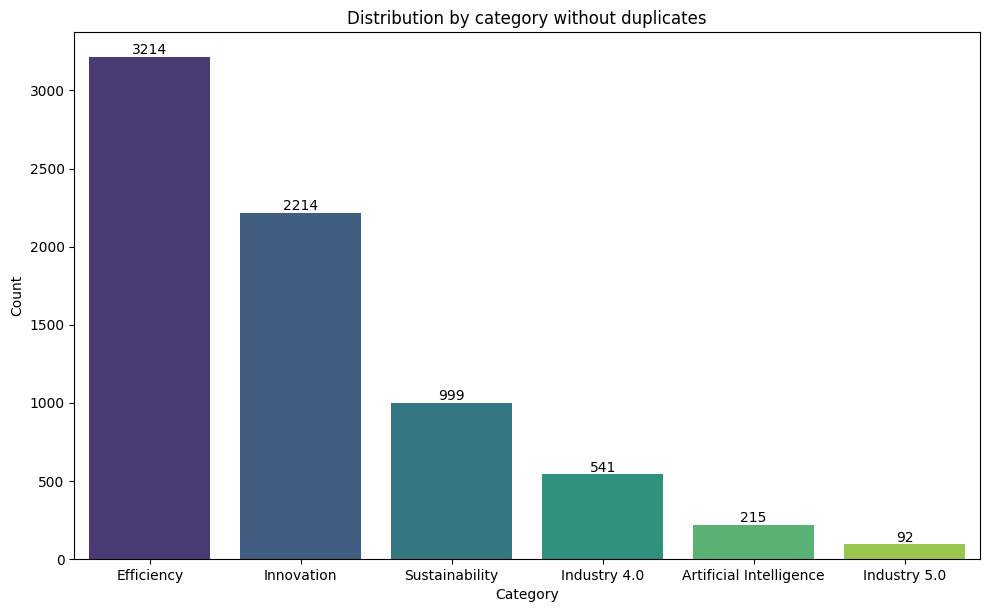

In [ ]:
# Calcular a contagem de cada categoria
contagem_categorias = df_sem_duplicados['Category'].value_counts()

# Criar o gráfico de barras com Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sem_duplicados, x='Category', order=contagem_categorias.index, palette='viridis')

# Ajustar os espaçamentos
plt.tight_layout()

# Definir rótulos dos eixos
plt.xlabel('Category')
plt.ylabel('Count')

# Definir título
plt.title('Distribution by category without duplicates')

# Adicionar os valores quantitativos acima de cada barra
for i, v in enumerate(contagem_categorias):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

In [ ]:
# Cria um stemmer em inglês que ignora stopwords
stemmer = SnowballStemmer("english", ignore_stopwords=True)

# Classe personalizada que realiza a contagem das palavras e aplica o stemmer
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# Instancia o vetorizador de contagem com stemming e stopwords em inglês
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

# Divide o conjunto de dados em treinamento (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(df_sem_duplicados["Data"], df_sem_duplicados["Category"], test_size=0.3, random_state=42)


## MultinomialNB

In [ ]:
# Definidos os parâmetros para testar
parameters_mnb = {
    'tfidf__use_idf': (True, False),
    'mnb__alpha': [0.1, 0.5, 1.0]
}

# Pipeline com os passos necessários
model_mnb = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB(fit_prior=False))
])

# GridSearchCV para encontrar a melhor combinação de parâmetros
grid_search_mnb = GridSearchCV(model_mnb, parameters_mnb, cv=5, scoring='accuracy')
grid_search_mnb.fit(X_train, y_train)

# Melhores parâmetros e pontuação
best_parameters_mnb = grid_search_mnb.best_params_
best_score_mnb = grid_search_mnb.best_score_

# Usado os melhores parâmetros para treinar e prever novamente
best_model_mnb = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer(use_idf=best_parameters_mnb['tfidf__use_idf'])),
    ('mnb', MultinomialNB(alpha=best_parameters_mnb['mnb__alpha'], fit_prior=False))
])

# Treine o modelo usando os melhores parâmetros e os dados de treinamento
best_model_mnb.fit(X_train, y_train)

# Salvando o modelo treinado
#joblib.dump(best_model_mnb, 'best_model_mnb.joblib')
joblib.dump(best_model_mnb, '/content/drive/MyDrive/Projectum/CNI/best_model_mnb.joblib')

# Imprimindo os melhores resultados e parâmetros
print("Melhores parâmetros:", best_parameters_mnb)
print("Melhor pontuação:", best_score_mnb)


Melhores parâmetros: {'mnb__alpha': 0.1, 'tfidf__use_idf': False}
Melhor pontuação: 0.6737988050228372


In [ ]:
# Carregando o modelo treinado
loaded_model = joblib.load('/content/drive/MyDrive/Projectum/CNI/best_model_mnb.joblib')

# Atribuindo os melhores parâmetros definidos na célula anterior
best_parameters_mnb = {'mnb__alpha': 0.1, 'tfidf__use_idf': False}

# Faça a previsão das categorias usando os dados de teste
predicted_mnb = loaded_model.predict(X_test)

# Calculando as métricas (accuracy, precision, recall, f-measure)
report_mnb = classification_report(y_test, predicted_mnb, zero_division=0)

# Calculando a matriz de confusão
confusion_mnb = confusion_matrix(y_test, predicted_mnb)

# Calculando a acurácia
accuracy_mnb = accuracy_score(y_test, predicted_mnb)

# Resultados das métricas
print("Acurácia:", accuracy_mnb)
print("\nClassification Report:\n", report_mnb)
print("\nMatriz de Confusão:\n", confusion_mnb)

Acurácia: 0.668804397617957

Classification Report:
                          precision    recall  f1-score   support

Artificial Intelligence       0.78      0.12      0.22        56
             Efficiency       0.77      0.69      0.73       990
           Industry 4.0       0.43      0.51      0.47       158
           Industry 5.0       0.00      0.00      0.00        29
             Innovation       0.67      0.85      0.75       661
         Sustainability       0.49      0.43      0.46       289

               accuracy                           0.67      2183
              macro avg       0.52      0.43      0.44      2183
           weighted avg       0.67      0.67      0.66      2183


Matriz de Confusão:
 [[  7   4  23   0  13   9]
 [  0 688  50   0 168  84]
 [  1  20  81   0  45  11]
 [  0  12   9   0   3   5]
 [  1  67  12   0 560  21]
 [  0 100  12   0  53 124]]


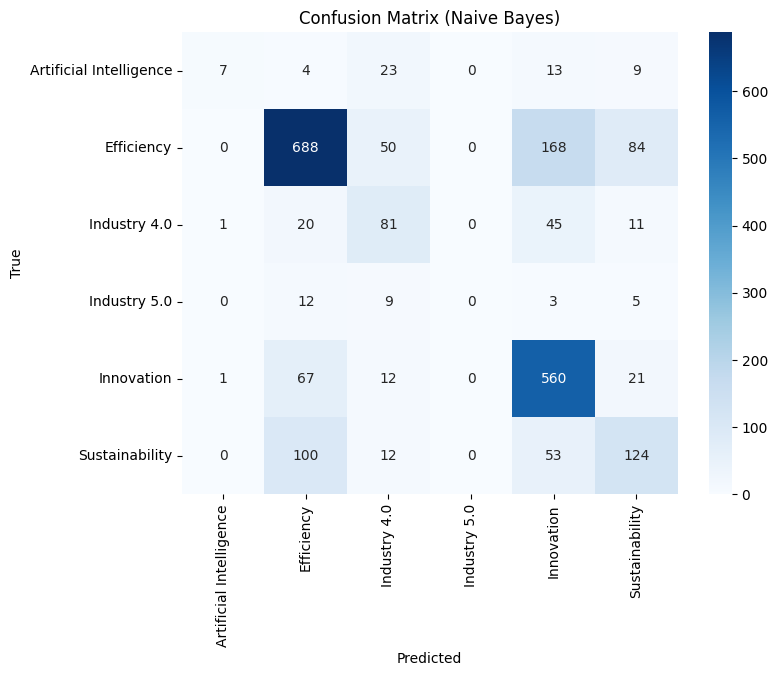

In [ ]:
# Obtém as categorias alvo do conjunto de teste
categories = np.unique(np.concatenate((y_test, predicted_mnb)))

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mnb, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

## SGDClassifier

In [ ]:
# Definidos os parâmetros que deseja testar
parameters_clf = {
    'tfidf__use_idf': (True, False),
    'clf-svm__alpha': (1e-2, 1e-3),  # Valores para o parâmetro alpha
    'clf-svm__max_iter': (20, 30, 40)  # Valores para o parâmetro max_iter
}

# Cria um pipeline para processar o texto e realizar a classificação com SGDClassifier
model_clf = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=18, random_state=42))])

# GridSearchCV com o pipeline e os parâmetros definidos
grid_search_clf = GridSearchCV(model_clf, parameters_clf)
grid_search_clf.fit(X_train, y_train)

# Obtenha a melhor combinação de parâmetros encontrada
best_params_clf = grid_search_clf.best_params_
best_score_clf = grid_search_clf.best_score_

# Crie um novo pipeline com os melhores parâmetros encontrados
best_model_clf = Pipeline([('vect', stemmed_count_vect),
                          ('tfidf', TfidfTransformer(use_idf=best_params_clf['tfidf__use_idf'])),
                          ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                    alpha=best_params_clf['clf-svm__alpha'],
                                                    max_iter=best_params_clf['clf-svm__max_iter'],
                                                    random_state=42))])

# Treine o modelo usando os melhores parâmetros e os dados de treinamento
best_model_clf.fit(X_train, y_train)

# Salvando o modelo treinado
#joblib.dump(best_model_clf, 'best_model_clf.joblib')
joblib.dump(best_model_clf, '/content/drive/MyDrive/Projectum/CNI/best_model_clf.joblib')

# Imprimindo os melhores resultados e parâmetros
print("Melhores parâmetros:", best_params_clf)
print("Melhor pontuação:", best_score_clf)

Melhores parâmetros: {'clf-svm__alpha': 0.001, 'clf-svm__max_iter': 20, 'tfidf__use_idf': False}
Melhor pontuação: 0.7358556772983259


In [ ]:
# Carregando o modelo treinado
loaded_model = joblib.load('/content/drive/MyDrive/Projectum/CNI/best_model_clf.joblib')

# Atribuindo os melhores parâmetros definidos na célula anterior
best_parameters_clf = {'clf-svm__alpha': 0.001, 'clf-svm__max_iter': 20, 'tfidf__use_idf': False}

# Faça a previsão das categorias usando os dados de teste
predicted_clf = loaded_model.predict(X_test)

# Calculando as métricas (accuracy, precision, recall, f-measure)
report_clf = classification_report(y_test, predicted_clf, zero_division=0)

# Calculando a matriz de confusão
confusion_clf = confusion_matrix(y_test, predicted_clf)

# Calculando a acurácia
accuracy_clf = accuracy_score(y_test, predicted_clf)

# Resultados das métricas
print("Acurácia:", accuracy_clf)
print("\nClassification Report:\n", report_clf)
print("\nMatriz de Confusão:\n", confusion_clf)

Acurácia: 0.7521759047182776

Classification Report:
                          precision    recall  f1-score   support

Artificial Intelligence       0.91      0.52      0.66        56
             Efficiency       0.74      0.92      0.82       990
           Industry 4.0       0.69      0.27      0.38       158
           Industry 5.0       0.00      0.00      0.00        29
             Innovation       0.77      0.80      0.79       661
         Sustainability       0.76      0.46      0.57       289

               accuracy                           0.75      2183
              macro avg       0.64      0.49      0.54      2183
           weighted avg       0.74      0.75      0.73      2183


Matriz de Confusão:
 [[ 29   7   8   0   8   4]
 [  0 909   2   0  62  17]
 [  3  62  42   0  44   7]
 [  0  19   3   0   4   3]
 [  0 118   2   0 530  11]
 [  0 115   4   0  38 132]]


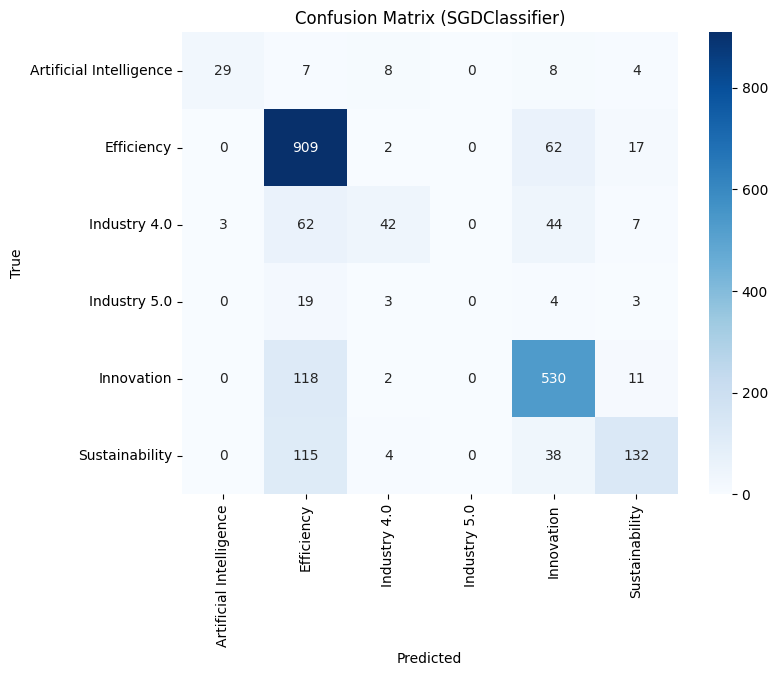

In [ ]:
# Obtém as categorias alvo do conjunto de teste
categories = np.unique(np.concatenate((y_test, predicted_clf)))

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_clf, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SGDClassifier)')
plt.show()


## SVM

In [ ]:
# Define a grade de hiperparâmetros a serem testados
parameters_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Cria um pipeline para processar o texto e realizar a classificação com SVM
model_svm = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC())])

# Realiza a busca em grade com validação cruzada
grid_search_svm = GridSearchCV(model_svm, parameters_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Obtenha a melhor combinação de parâmetros encontrada
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

# Obtém o melhor modelo encontrado
best_model_svm = grid_search_svm.best_estimator_

# Salvando o modelo treinado
#joblib.dump(best_model_svm, 'best_model_svm.joblib')
joblib.dump(best_model_svm, '/content/drive/MyDrive/Projectum/CNI/best_model_svm.joblib')

# Imprimirindo os melhores parametros e pontuação
print("Melhores parâmetros:", best_params_svm)
print("Melhor pontuação:", best_score_svm)

Melhores parâmetros: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Melhor pontuação: 0.7384091264019002


In [ ]:
# Carregando o modelo treinado
loaded_model = joblib.load('/content/drive/MyDrive/Projectum/CNI/best_model_svm.joblib')

# Atribuindo os melhores parâmetros definidos na célula anterior
best_parameters_svm = {'clf-svm__alpha': 0.001, 'clf-svm__max_iter': 20, 'tfidf__use_idf': False}

# Faz a previsão das categorias usando os dados de teste
predicted_svm = loaded_model.predict(X_test)

# Calculando as métricas (accuracy, precision, recall, f-measure)
report_svm = classification_report(y_test, predicted_svm, zero_division=0)

# Calculando a matriz de confusão
confusion_svm = confusion_matrix(y_test, predicted_svm)

# Calculando a acurácia
accuracy_svm = accuracy_score(y_test, predicted_svm)

# Resultados das métricas
print("Acurácia:", accuracy_svm)
print("\nClassification Report:\n", report_svm)
print("\nMatriz de Confusão:\n", confusion_svm)


Acurácia: 0.749885478699038

Classification Report:
                          precision    recall  f1-score   support

Artificial Intelligence       0.89      0.55      0.68        56
             Efficiency       0.75      0.88      0.81       990
           Industry 4.0       0.60      0.55      0.57       158
           Industry 5.0       0.00      0.00      0.00        29
             Innovation       0.78      0.78      0.78       661
         Sustainability       0.71      0.45      0.55       289

               accuracy                           0.75      2183
              macro avg       0.62      0.54      0.57      2183
           weighted avg       0.74      0.75      0.74      2183


Matriz de Confusão:
 [[ 31   7  10   0   6   2]
 [  1 873  15   0  76  25]
 [  1  41  87   0  24   5]
 [  0  15   7   0   2   5]
 [  1 116  11   0 517  16]
 [  1 107  15   0  37 129]]


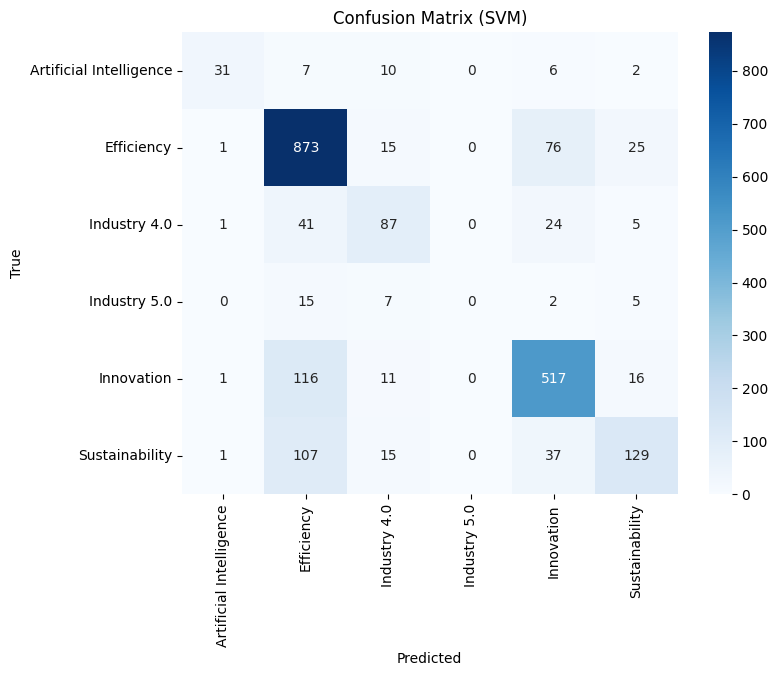

In [ ]:
# Obtém as categorias alvo do conjunto de teste
categories = np.unique(np.concatenate((y_test, predicted_svm)))

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_svm, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM)')
plt.show()

## Decision Tree

In [ ]:
# Cria um pipeline para processar o texto e realizar a classificação com Árvore de Decisão
model_dt = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('decision_tree', DecisionTreeClassifier())  # Usamos o DecisionTreeClassifier para Árvore de Decisão
])

# Define os hiperparâmetros a serem ajustados
parameters_dt = {
    'decision_tree__max_depth': [None, 10, 20],
    'decision_tree__criterion': ['gini', 'entropy'],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4]
}

# Realiza a busca em grid para encontrar os melhores hiperparâmetros
grid_search_dt = GridSearchCV(model_dt, parameters_dt, cv=5)
grid_search_dt.fit(X_train, y_train)

# Obtenha a melhor combinação de parâmetros encontrada
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

# Obtém o melhor modelo encontrado
best_model_dt = grid_search_dt.best_estimator_

# Salvando o modelo treinado
#joblib.dump(best_model_dt, 'best_model_dt.joblib')
joblib.dump(best_model_dt, '/content/drive/MyDrive/Projectum/CNI/best_model_dt.joblib')

# Imprimindo os melhores resultados e parâmetros
print("Melhores parâmetros:", best_params_dt)
print("Melhor pontuação:", best_score_dt)

Melhores parâmetros: {'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 10, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 5}
Melhor pontuação: 0.7598171094971571


In [ ]:
# Carregando o modelo treinado
loaded_model = joblib.load('/content/drive/MyDrive/Projectum/CNI/best_model_dt.joblib')

# Atribuindo os melhores parâmetros definidos na célula anterior
best_parameters_dt = {'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 10, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 10}

# Faz a previsão das categorias usando o modelo com os melhores hiperparâmetros
predicted_dt = loaded_model.predict(X_test)

# Calculando as métricas (accuracy, precision, recall, f-measure)
report_dt = classification_report(y_test, predicted_dt, zero_division=0)

# Calculando a matriz de confusão
confusion_dt = confusion_matrix(y_test, predicted_dt)

# Calculando a acurácia
accuracy_dt = accuracy_score(y_test, predicted_dt)

# Resultados das métricas
print("Acurácia:", accuracy_dt)
print("\nClassification Report:\n", report_dt)
print("\nMatriz de Confusão:\n", confusion_dt)

Acurácia: 0.7691250572606505

Classification Report:
                          precision    recall  f1-score   support

Artificial Intelligence       0.96      0.82      0.88        56
             Efficiency       0.79      0.87      0.83       990
           Industry 4.0       0.54      0.39      0.45       158
           Industry 5.0       0.00      0.00      0.00        29
             Innovation       0.80      0.79      0.80       661
         Sustainability       0.67      0.63      0.65       289

               accuracy                           0.77      2183
              macro avg       0.63      0.58      0.60      2183
           weighted avg       0.75      0.77      0.76      2183


Matriz de Confusão:
 [[ 46   3   0   0   5   2]
 [  0 866  21   0  64  39]
 [  0  63  62   0  22  11]
 [  1  13   4   0   5   6]
 [  0  90  17   0 523  31]
 [  1  61  11   1  33 182]]


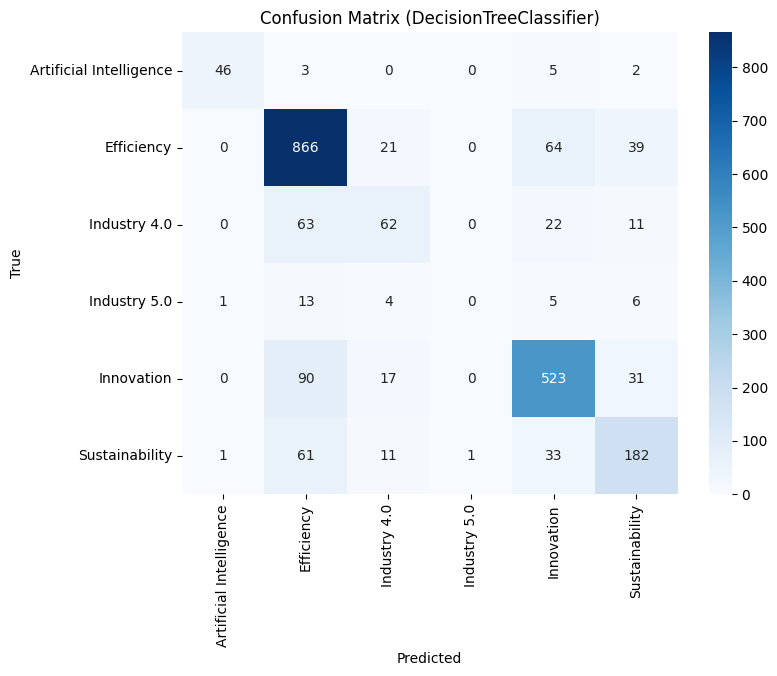

In [ ]:
# Obtém as categorias alvo do conjunto de teste
categories = np.unique(np.concatenate((y_test, predicted_dt)))

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_dt, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (DecisionTreeClassifier)')
plt.show()

## Random Forest Classifier

In [ ]:
# Cria um pipeline para processar o texto e realizar a classificação com Random Forest
model_rf = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('random_forest', RandomForestClassifier())  # Usamos RandomForestClassifier em vez de DecisionTreeClassifier
])

# Define os hiperparâmetros a serem ajustados para o Random Forest
parameters_rf = {
    'random_forest__n_estimators': [50, 100, 200],  # Número de árvores no ensemble
    'random_forest__max_depth': [None, 10, 20],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4]
}

# Realiza a busca em grid para encontrar os melhores hiperparâmetros
grid_search_rf = GridSearchCV(model_rf, parameters_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

# Obtenha a melhor combinação de parâmetros encontrada
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Obtém o melhor modelo encontrado
best_model_rf = grid_search_rf.best_estimator_

# Salvando o modelo treinado
#joblib.dump(best_model_rf, 'best_model_rf.joblib')
joblib.dump(best_model_rf, '/content/drive/MyDrive/Projectum/CNI/best_model_rf.joblib')

# Imprimindo os melhores resultados e parâmetros
print("Melhores parâmetros:", best_params_rf)
print("Melhor pontuação:", best_score_rf)

Melhores parâmetros: {'random_forest__max_depth': None, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 200}
Melhor pontuação: 0.7364496954716959


In [ ]:
# Carregando o modelo treinado
loaded_model = joblib.load('/content/drive/MyDrive/Projectum/CNI/best_model_rf.joblib')

# Atribuindo os melhores parâmetros definidos na célula anterior
best_parameters_rf = {'random_forest__max_depth': None, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 200}

# Faz a previsão das categorias usando o modelo com os melhores hiperparâmetros
predicted_rf = loaded_model.predict(X_test)

# Calculando as métricas (accuracy, precision, recall, f-measure)
report_rf = classification_report(y_test, predicted_rf, zero_division=0)

# Calculando a matriz de confusão
confusion_rf = confusion_matrix(y_test, predicted_rf)

# Calculando a acurácia
accuracy_rf = accuracy_score(y_test, predicted_rf)

# Resultados das métricas
print("Acurácia:", accuracy_rf)
print("\nClassification Report:\n", report_rf)
print("\nMatriz de Confusão:\n", confusion_rf)


Acurácia: 0.7343105817682088

Classification Report:
                          precision    recall  f1-score   support

Artificial Intelligence       1.00      0.38      0.55        56
             Efficiency       0.73      0.93      0.81       990
           Industry 4.0       0.68      0.28      0.40       158
           Industry 5.0       0.00      0.00      0.00        29
             Innovation       0.74      0.84      0.79       661
         Sustainability       0.81      0.22      0.34       289

               accuracy                           0.73      2183
              macro avg       0.66      0.44      0.48      2183
           weighted avg       0.73      0.73      0.70      2183


Matriz de Confusão:
 [[ 21  13  11   0  10   1]
 [  0 916   0   0  70   4]
 [  0  60  45   0  50   3]
 [  0  19   2   0   3   5]
 [  0 101   0   0 558   2]
 [  0 151   8   0  67  63]]


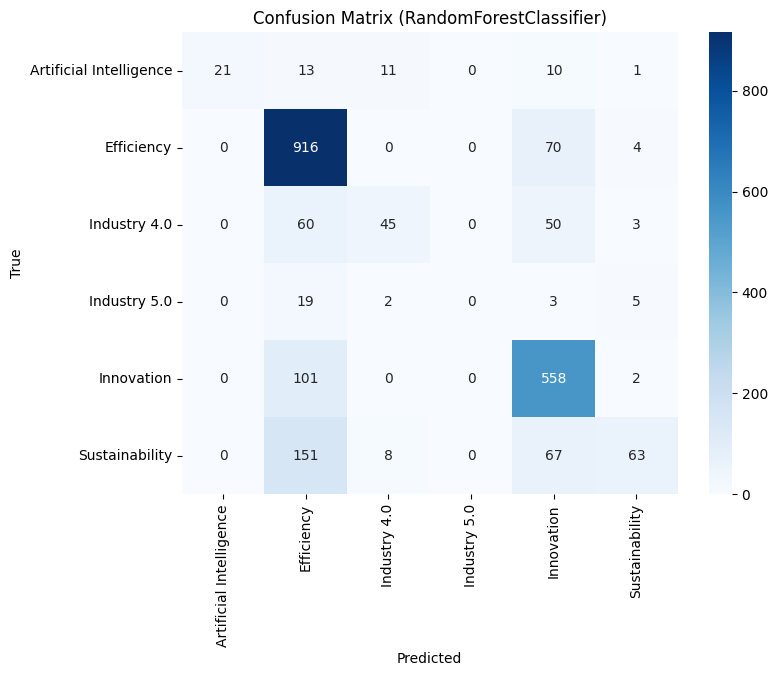

In [ ]:
# Obtém as categorias alvo do conjunto de teste
categories = np.unique(np.concatenate((y_test, predicted_rf)))

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_rf, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (RandomForestClassifier)')
plt.show()